<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Agenda" data-toc-modified-id="Agenda-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Agenda</a></span></li><li><span><a href="#Preparing-Data" data-toc-modified-id="Preparing-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Data</a></span></li><li><span><a href="#Fitting-a-Line-to-$Logit(target)$" data-toc-modified-id="Fitting-a-Line-to-$Logit(target)$-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fitting a Line to $Logit(target)$</a></span><ul class="toc-item"><li><span><a href="#sklearn.linear_model.LogisticRegression()" data-toc-modified-id="sklearn.linear_model.LogisticRegression()-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><code>sklearn.linear_model.LogisticRegression()</code></a></span></li><li><span><a href="#.predict()-vs.-.predict_proba()" data-toc-modified-id=".predict()-vs.-.predict_proba()-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>.predict()</code> vs. <code>.predict_proba()</code></a></span></li><li><span><a href="#Cost-Functions-and-Solutions-to-the-Optimization-Problem" data-toc-modified-id="Cost-Functions-and-Solutions-to-the-Optimization-Problem-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Cost Functions and Solutions to the Optimization Problem</a></span><ul class="toc-item"><li><span><a href="#The-bad-news:" data-toc-modified-id="The-bad-news:-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>The bad news:</a></span></li><li><span><a href="#The-good-news:" data-toc-modified-id="The-good-news:-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>The good news:</a></span></li></ul></li><li><span><a href="#Interpreting-Logistic-Regression-Coefficients" data-toc-modified-id="Interpreting-Logistic-Regression-Coefficients-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Interpreting Logistic Regression Coefficients</a></span><ul class="toc-item"><li><span><a href="#Use-Coefficients-to-Generate-Prediction" data-toc-modified-id="Use-Coefficients-to-Generate-Prediction-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Use Coefficients to Generate Prediction</a></span></li></ul></li></ul></li><li><span><a href="#Exercise" data-toc-modified-id="Exercise-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise</a></span></li><li><span><a href="#Level-Up" data-toc-modified-id="Level-Up-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Level Up</a></span><ul class="toc-item"><li><span><a href="#More-Generalizations:-Other-Link-Functions,-Other-Models" data-toc-modified-id="More-Generalizations:-Other-Link-Functions,-Other-Models-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>More Generalizations: Other Link Functions, Other Models</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss

# For demonstrative pruposes
from scipy.special import logit, expit

# Agenda

SWBAT:

- Explain the form of logistic regression
- Explain how to interpret logistic regression coefficients
- Use logistic regression to perform a classification task

# Preparing Data

In [2]:
# glass identification dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
glass = pd.read_csv(url, names=col_names, index_col='id')
glass.sort_values('al', inplace=True)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1


In [3]:
# types 1, 2, 3 are window glass
# types 5, 6, 7 are household glass
glass['household'] = glass.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0


# Fitting a Line to $Logit(target)$

>Nonlinear transformation of a logistic to linear

Let's try applying the logit function to our target and then fitting a linear regression to that. Since the model will be trained not on whether the glass is household but rather on *the logit of this label*, it will also make predictions of the logit of that label. But we can simply apply the sigmoid function to the model's output to get its predictions of whether the glass is household.

We can't use the target as is, because the logit of 1 is $\infty$ and the logit of 0 is $-\infty$.

In [4]:
glass['household'].unique()

array([0, 1])

In [5]:
logit(glass['household']).unique()

array([-inf,  inf])

So we'll make a small adjustment:

>approximation of infinity

In [6]:
target_approx = np.where(glass['household'] == 0, 1e-9, 1-1e-9)

In [7]:
line_to_logit = LinearRegression()

X = glass[['al']]
y = logit(target_approx)

line_to_logit.fit(X, y)

LinearRegression()

>expit is the inverse of the logit function It is bringing the infities to 0 and 1

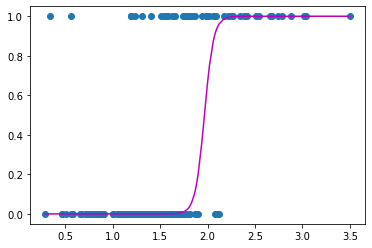

In [8]:
fig, ax = plt.subplots()

final_preds = expit(line_to_logit.predict(X))
ax.scatter(X, glass['household'])
ax.plot(X, final_preds, 'm');

>The threshold switches at 2. The ones that are not in the line are the incorrect ones.

## `sklearn.linear_model.LogisticRegression()`

In general, we should always scale our data when using this class. Scaling is always important for models that include regularization, and scikit-learn's `LogisticRegression()` objects have regularization by default.

Here we've forgone the scaling since we only have a single predictor.

In [9]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression(random_state=42)
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
logreg.fit(X, y)
glass['household_pred_class'] = logreg.predict(X)

In [11]:
glass #The last column is the predictions

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household,household_pred_class
id,,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.00,0.00,1,0,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.00,0.00,6,1,0
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.00,0.00,1,0,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.00,0.00,1,0,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.00,0.16,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
193,1.51623,14.20,0.00,2.79,73.46,0.04,9.04,0.40,0.09,7,1,1
210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.00,7,1,1
173,1.51321,13.00,0.00,3.02,70.70,6.21,6.93,0.00,0.00,5,1,1


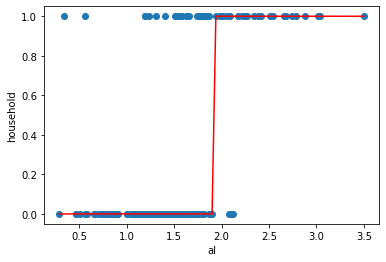

In [12]:
# plot the class predictions

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_class, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

## `.predict()` vs. `.predict_proba()`

Let's checkout some specific examples to make predictions with. We'll use both `predict()` and `predict_proba()`.

In [13]:
glass.al

id
22     0.29
185    0.34
40     0.47
39     0.47
51     0.51
       ... 
193    2.79
210    2.88
173    3.02
172    3.04
164    3.50
Name: al, Length: 214, dtype: float64

In [14]:
# examine some example predictions

print(logreg.predict(glass['al'][22].reshape(1, -1)))
print(logreg.predict(glass['al'][185].reshape(1, -1)))
print(logreg.predict(glass['al'][164].reshape(1, -1)))
print('\n')
print(logreg.predict_proba(glass['al'][22].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][185].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][164].reshape(1, -1))[0])
first_row = glass['al'][22].reshape(1, -1)

[0]
[0]
[1]


[0.9939759 0.0060241]
[0.99296771 0.00703229]
[0.00743731 0.99256269]


In [15]:
# store the predicted probabilites of class 1
glass['household_pred_prob'] = logreg.predict_proba(X)[:, 1]

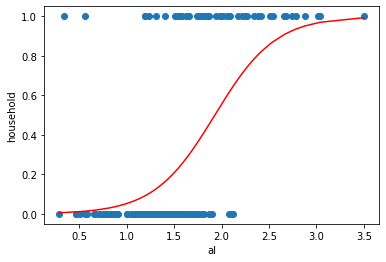

In [16]:
# plot the predicted probabilities
fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_prob, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

>as we get further to the right or left we can be more certain of what the classification is

The first column indicates the predicted probability of **class 0**, and the second column indicates the predicted probability of **class 1**.

In [17]:
log_loss(glass.household, logreg.predict_proba(X)[:, 1])

0.36150680872607704

The above is a pretty good score. A baseline classifier that is fit on data with equal numbers of data points in the two target classes should be right about 50% of the time, and the log loss for such a classifier would be $-ln(0.5) = 0.693$.

In [18]:
-np.log(0.5)

0.6931471805599453

## Cost Functions and Solutions to the Optimization Problem

Unlike the least-squares problem for linear regression, no one has yet found a closed-form solution to the optimization problem presented by logistic regression. But even if one exists, the computation would no doubt be so complex that we'd be better off using some sort of approximation method instead.

But there's still a problem.

Recall the cost function for linear regression: <br/><br/>
$SSE = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i(y_i - (\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in}))^2$.

This function, $SSE(\vec{\beta})$, is convex.

If we plug in our new logistic equation for $\hat{y}$, we get: <br/><br/>
$SSE_{log} = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i\left(y_i - \left(\frac{1}{1+e^{-(\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in})}}\right)\right)^2$.

### The bad news:

*This* function, $SSE_{log}(\vec{\beta})$, is [**not** convex](https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c).

That means that, if we tried to use gradient descent or some other approximation method that looks for the minimum of this function, we could easily find a local rather than a global minimum.

> Note that the scikit-learn class *expects the user to specify the solver* to be used in calculating the coefficients. The default solver, [lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS), works well for many applications.

### The good news:

>Log loss is better for gradient descent

>more mistakes value is larger less is smaller the better the function the smaller the value

We can use **log-loss** instead:

$\mathcal{L}(\vec{y}, \hat{\vec{y}}) = -\frac{1}{N}\Sigma^N_{i=1}\left(y_iln(\hat{y}_i)+(1-y_i)ln(1-\hat{y}_i)\right)$,

where $\hat{y}_i$ is the probability that $(x_{i1}, ... , x_{in})$ belongs to **class 1**.

**More resources on the log-loss function**:

https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

http://wiki.fast.ai/index.php/Log_Loss

## Interpreting Logistic Regression Coefficients

>factor of e ^ k relative to the odds ratio

In [19]:
logreg.coef_

array([[3.11517927]])

How do we interpret the coefficients of a logistic regression? For a linear regression, the situaton was like this:

- Linear Regression: We construct the best-fit line and get a set of coefficients. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change in $y$.

- Logistic Regression: We find the coefficients of the best-fit line by some approximation method. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change (not in $y$ but) in $ln\left(\frac{y}{1-y}\right)$.

We have:

$\ln\left(\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}\right) = \ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k$.

Exponentiating both sides:

$\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)} = e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k}$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right)}\cdot e^k$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^k\cdot\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}$

That is, the odds ratio at $x_1+1$ has increased by a factor of $e^k$ relative to the odds ratio at $x_1$.

For more on interpretation, see [this page](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/binary-logistic-regression/interpret-the-results/all-statistics-and-graphs/coefficients/).

In [20]:
# examine the intercept

logreg.intercept_

array([-6.00934605])

**Interpretation:** For an 'al' value of 0, the log-odds of 'household' is -6.01.

In [21]:
# convert log-odds to probability

logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.00244968])

>The coefficient reversed tells you how much the prob will increase based on the x value

In [22]:
# examine the coefficient for al

list(zip(feature_cols, logreg.coef_[0]))

[('al', 3.1151792681570165)]

**Interpretation:** A 1 unit increase in 'al' is associated with a 3.12 unit increase in the log-odds of 'household'.

Let's verify this as we change the aluminum content from 1 to 2.

In [23]:
# Prediction for al=1

pred_al1 = logreg.predict_proba([[1]])
pred_al1

array([[0.94755733, 0.05244267]])

In [24]:
# Odds ratio for al=1

odds_al1 = pred_al1[0][1] / pred_al1[0][0]

In [25]:
# Prediction for al=2
pred_al2 = logreg.predict_proba([[2]])
pred_al2

array([[0.4449707, 0.5550293]])

In [26]:
# Odds ratio for al=2

odds_al2 = pred_al2[0][1] / pred_al2[0][0]

In [27]:
print((np.exp(logreg.coef_[0]) * odds_al1)[0])
print(odds_al2)

1.2473390003597826
1.2473390003597828


>Interpretting coefficients: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/binary-logistic-regression/interpret-the-results/all-statistics-and-graphs/coefficients/

### Use Coefficients to Generate Prediction

In [ ]:
# compute predicted log-odds for al=2 using the equation

logodds = logreg.intercept_ + logreg.coef_[0] * 2
logodds

In [ ]:
# convert log-odds to odds

odds = np.exp(logodds)
odds

In [ ]:
# convert odds to probability

prob = odds / (1 + odds)
prob

In [ ]:
# compute predicted probability for al=2 using the predict_proba method

logreg.predict_proba(np.array([2]).reshape(1, 1))[:, 1]

# Exercise

Split the data below into train and test, and then convert the y-values (`geysers.kind`) into 1's and 0's. Then use `sklearn` to build a logistic regression model of whether Old Faithful's eruption wait time is long or short, based on the duration of the eruption. Finally, find the points in the test set where the model's prediction differs from the true y-value. How many are there?

In [28]:
geysers = sns.load_dataset('geyser', **{'usecols': ['duration', 'kind']})

In [29]:
geysers.head()

,duration,kind
0,3.600,long
1,1.800,short
2,3.333,long
3,2.283,short
4,4.533,long


In [31]:
geysers['erup'] = np.where(geysers['kind'] =='long', 1, 0)
geysers.head()

,duration,kind,erup
0,3.600,long,1
1,1.800,short,0
2,3.333,long,1
3,2.283,short,0
4,4.533,long,1


In [33]:
# Train test split
X = geysers.duration
y = geysers.erup

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [34]:
#Normalize
X_train_norm = normalize(X_train.to_numpy().reshape(-1,1))

In [35]:
# Define & Fit Model (with train)
model = LogisticRegression()
#Fit
model.fit(X_train_norm, y_train)

LogisticRegression()

In [36]:
model.score(X_train_norm, y_train)

0.631336405529954

In [40]:
residuals = (y_train == model.predict(X_train_norm))
residuals
pd.Series(residuals).value_counts()

True     137
False     80
Name: erup, dtype: int64

In [46]:
yhat = model.predict(normalize(X_test.to_numpy().reshape(-1,1)))

In [51]:
residuals = (y_test == yhat)
pd.Series(residuals).value_counts()

35/55

0.6363636363636364

# Level Up

## More Generalizations: Other Link Functions, Other Models

Logistic regression's link function is the logit function, but different sorts of models use different link functions.

[Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) has a nice table of generalized linear model types and their associated link functions.